In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import ScalarFormatter
from scipy.stats import linregress
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import pickle
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from scipy.optimize import curve_fit, least_squares
from matplotlib.colors import LinearSegmentedColormap


In [11]:
def get_all_pkl_files(base_dir):
    pkl_files = []
    for root, dirs, files in os.walk(base_dir):
        if "_new" in root:
            for file in files:
                if file.endswith(".pkl"):
                    pkl_files.append(os.path.join(root, file))
    return pkl_files

In [12]:
base_directory = "/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104PIV_data_fine/"


In [13]:
def get_all_pkl_files(base_dir):
    pkl_files = []
    for root, dirs, files in os.walk(base_dir):
        if "_finer" in root:
            for file in files:
                if file.endswith(".pkl"):
                    pkl_files.append(os.path.join(root, file))
    return pkl_files

In [14]:
def compute_correlation(velocity_data, frame_rate, start_frame=90, end_frame=110):
    # Get the shape of the velocity field from the first frame
    first_frame = list(velocity_data.keys())[0]
    UX, UY = velocity_data[first_frame]
    size_y, size_x = UX.shape

    # Select middle ±3 grid points in y-direction (equivalent to ±100 pixels)
    mid_y = size_y // 2
    start_y = max(mid_y - 4, 0)
    end_y = min(mid_y + 4, size_y)

    # Ignore the leftmost 10 vectors and the rightmost 3 vectors
    start_x = 10
    end_x = size_x - 5  # Discard the rightmost 3 vectors

    # Compute mean velocity (ignoring the leftmost 10 vectors and the rightmost 3 vectors)
    mean_UX = np.mean([velocity_data[t][0][start_y:end_y, start_x:end_x] for t in range(start_frame, end_frame)])
    mean_UY = np.mean([velocity_data[t][1][start_y:end_y, start_x:end_x] for t in range(start_frame, end_frame)])

    correlations = []

    for frame in range(start_frame, end_frame):
        UX, UY = velocity_data[frame]
        frame_correlation = []
        
        # Use the reference vector (last vector before the excluded rightmost 3 vectors)
        ux_fluct_right = UX[start_y:end_y, end_x - 1] - mean_UX
        uy_fluct_right = UY[start_y:end_y, end_x - 1] - mean_UY
        
        for x in range(end_x - 1, start_x - 1, -1):  # Start from the new reference point and move left
            ux_fluct_current = UX[start_y:end_y, x] - mean_UX
            uy_fluct_current = UY[start_y:end_y, x] - mean_UY

            numerator = np.mean(ux_fluct_right * ux_fluct_current + uy_fluct_right * uy_fluct_current)
            denominator = np.sqrt(np.mean(ux_fluct_right**2 + uy_fluct_right**2) * 
                                  np.mean(ux_fluct_current**2 + uy_fluct_current**2))
            
            correlation = numerator / denominator
            frame_correlation.append(correlation)
        
        correlations.append(frame_correlation)

    # Average over frames
    avg_correlation = np.mean(correlations, axis=0)

    return avg_correlation


/tmp/ipykernel_2494391/3453263754.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


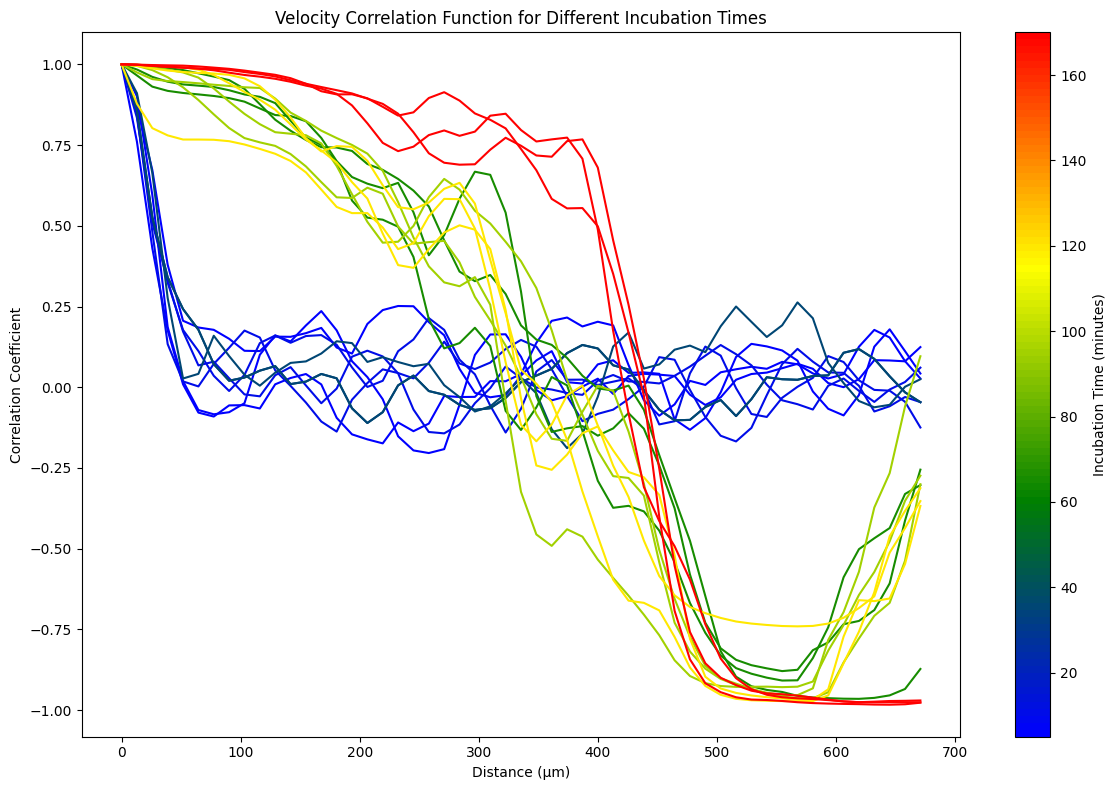

Overall max correlation: 1.0
Overall min correlation: -0.9830366969108582
Overall mean correlation: 0.09537475556135178


In [15]:



# Create a custom colormap
colors = ['blue', 'green', 'yellow', 'red']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

plt.figure(figsize=(12, 8))

# Collect incubation times and correlations
data = []

# Process each folder
for folder in os.listdir(base_directory):
    if folder.endswith('_finer'):
        folder_path = os.path.join(base_directory, folder)
        
        # Extract incubation time
        incubation_time = folder.split('_')[0]
        if incubation_time == '5':
            incubation_time = 5  # Handle the '5_min' case
        else:
            incubation_time = int(incubation_time)
        
        # Find the pickle file
        pkl_file = None
        for file in os.listdir(folder_path):
            if file.endswith(".pkl"):
                pkl_file = os.path.join(folder_path, file)
                break
        
        if pkl_file is not None:
            frame_rate = 0.1  # frames per second

            with open(pkl_file, 'rb') as f:
                velocity_data = pickle.load(f)
                correlation = compute_correlation(velocity_data, frame_rate)
            
            data.append((incubation_time, correlation))

# Sort the data by incubation time
data.sort(key=lambda x: x[0])

# Separate sorted times and correlations
incubation_times, all_correlations = zip(*data)

# Plot the correlations
for time, correlation in zip(incubation_times, all_correlations):
    plt.plot(np.arange(len(correlation)) * 0.43 * 30, correlation, 
             color=cmap((time - min(incubation_times)) / (max(incubation_times) - min(incubation_times))))

plt.xlabel('Distance (µm)')
plt.ylabel('Correlation Coefficient')
plt.title('Velocity Correlation Function for Different Incubation Times')

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(incubation_times), vmax=max(incubation_times)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Incubation Time (minutes)')

plt.tight_layout()
plt.show()

# Print some overall statistics
all_correlations_flat = [item for sublist in all_correlations for item in sublist]
print(f"Overall max correlation: {np.max(all_correlations_flat)}")
print(f"Overall min correlation: {np.min(all_correlations_flat)}")
print(f"Overall mean correlation: {np.mean(all_correlations_flat)}")

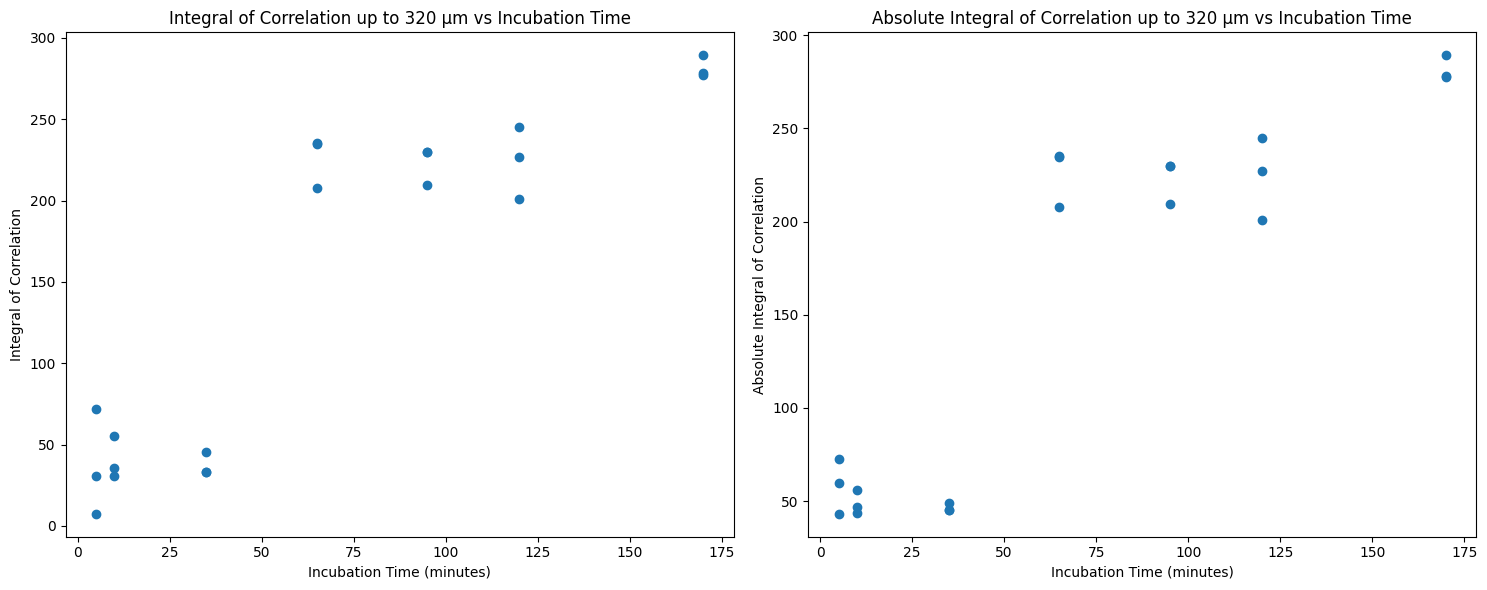

    incubation_time    integral  abs_integral  integration_distance_um
0                 5    7.468400     43.221314                    309.6
1                 5   30.643169     59.650125                    309.6
2                 5   71.886880     72.740885                    309.6
3                10   55.007894     55.892854                    309.6
4                10   35.747324     43.896095                    309.6
5                10   30.586808     47.073519                    309.6
6                35   33.342659     45.049158                    309.6
7                35   33.342659     45.049158                    309.6
8                35   45.574163     49.189740                    309.6
9                65  207.701965    207.701965                    309.6
10               65  235.402233    235.402233                    309.6
11               65  234.786121    234.786121                    309.6
12               95  229.693827    229.693827                    309.6
13    

In [18]:
def analyze_correlation_fixed(correlation, distance, fixed_distance_um=320):
    # Convert grid points to micrometers
    distance_um = distance * 30 * 0.43
    
    # Find the index corresponding to 320 μm
    integration_limit = np.searchsorted(distance_um, fixed_distance_um)
    
    # Ensure we don't go out of bounds
    integration_limit = min(integration_limit, len(correlation))
    
    # Compute the integral up to the fixed distance
    integral = integrate.simps(correlation[:integration_limit], distance_um[:integration_limit])
    
    # Compute absolute integral
    abs_integral = integrate.simps(np.abs(correlation[:integration_limit]), distance_um[:integration_limit])
    
    return {
        'integral': integral,
        'abs_integral': abs_integral,
        'integration_distance_um': distance_um[integration_limit - 1]
    }

# In your main loop:
results = []
for time, correlation in zip(incubation_times, all_correlations):
    distance = np.arange(len(correlation))
    analysis = analyze_correlation_fixed(correlation, distance)
    results.append({
        'incubation_time': time,
        **analysis
    })

# Convert results to a DataFrame for easy analysis
df_results = pd.DataFrame(results)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Integral vs Incubation Time
ax1.scatter(df_results['incubation_time'], df_results['integral'])
ax1.set_xlabel('Incubation Time (minutes)')
ax1.set_ylabel('Integral of Correlation')
ax1.set_title('Integral of Correlation up to 320 μm vs Incubation Time')

# Absolute Integral vs Incubation Time
ax2.scatter(df_results['incubation_time'], df_results['abs_integral'])
ax2.set_xlabel('Incubation Time (minutes)')
ax2.set_ylabel('Absolute Integral of Correlation')
ax2.set_title('Absolute Integral of Correlation up to 320 μm vs Incubation Time')

plt.tight_layout()
plt.show()

print(df_results)

In [20]:
def compute_correlation_magnitude(velocity_data, frame_rate, start_frame=90, end_frame=100):
    # Get the shape of the velocity field from the first frame
    first_frame = list(velocity_data.keys())[0]
    UX, UY = velocity_data[first_frame]
    size_y, size_x = UX.shape

    # Select middle ±3 grid points in y-direction (equivalent to ±100 pixels)
    mid_y = size_y // 2
    start_y = max(mid_y - 3, 0)
    end_y = min(mid_y + 3, size_y)

    # Ignore the leftmost 10 vectors
    start_x = 10

    # Compute mean velocity (ignoring the leftmost 10 vectors)
    mean_UX = np.mean([velocity_data[t][0][start_y:end_y, start_x:] for t in range(start_frame, end_frame)])
    mean_UY = np.mean([velocity_data[t][1][start_y:end_y, start_x:] for t in range(start_frame, end_frame)])
    correlations = []

    for frame in range(start_frame, end_frame):
        UX, UY = velocity_data[frame]
        frame_correlation = []
        
        # Use the rightmost vector as reference
        ux_fluct_right = UX[start_y:end_y, -1] - mean_UX
        uy_fluct_right = UY[start_y:end_y, -1] - mean_UY
        
        for x in range(size_x-1, start_x-1, -1):  # Start from rightmost and move left, but stop at start_x
            ux_fluct_current = UX[start_y:end_y, x] - mean_UX
            uy_fluct_current = UY[start_y:end_y, x] - mean_UY

            # Compute correlation without normalization
            correlation = np.mean(ux_fluct_right * ux_fluct_current + uy_fluct_right * uy_fluct_current)
            
            frame_correlation.append(correlation)
        
        correlations.append(frame_correlation)

    # Average over frames
    avg_correlation = np.mean(correlations, axis=0)

    return avg_correlation

/tmp/ipykernel_2494391/1544527568.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


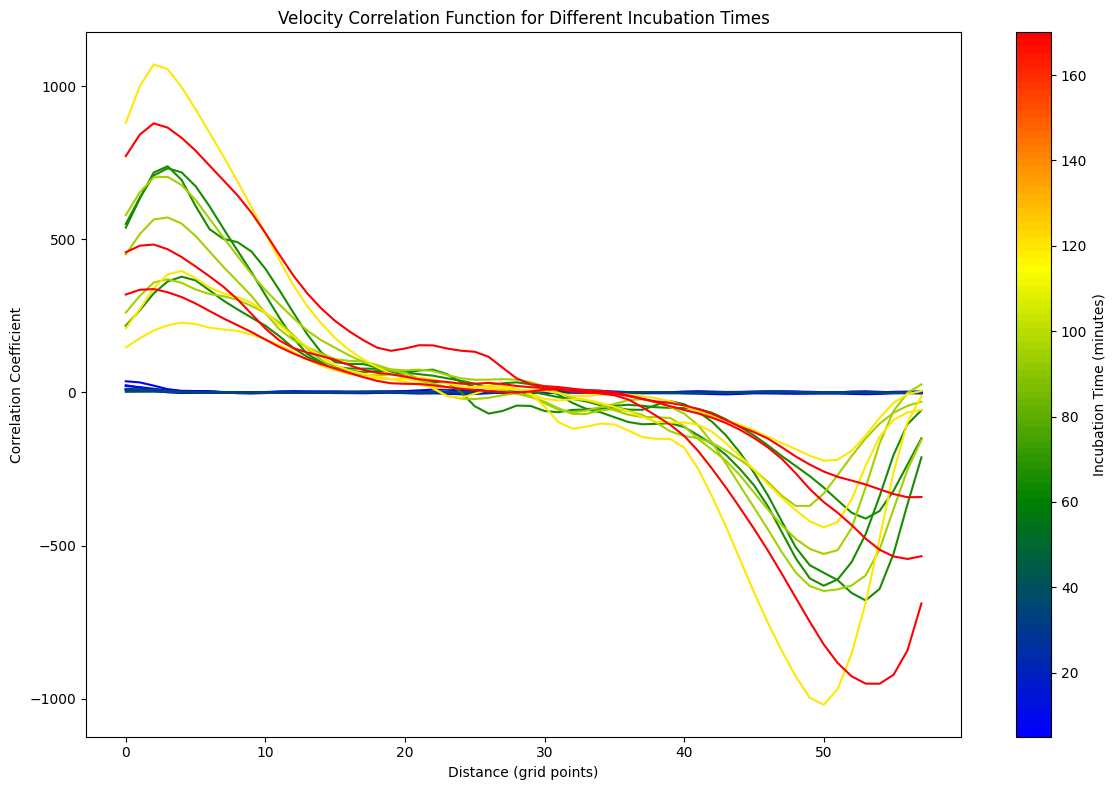

Overall max correlation: 1071.0577392578125
Overall min correlation: -1019.7418823242188
Overall mean correlation: 3.3489816188812256


In [21]:



# Create a custom colormap
colors = ['blue', 'green', 'yellow', 'red']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

plt.figure(figsize=(12, 8))

# Collect incubation times and correlations
data = []

# Process each folder
for folder in os.listdir(base_directory):
    if folder.endswith('_finer'):
        folder_path = os.path.join(base_directory, folder)
        
        # Extract incubation time
        incubation_time = folder.split('_')[0]
        if incubation_time == '5':
            incubation_time = 5  # Handle the '5_min' case
        else:
            incubation_time = int(incubation_time)
        
        # Find the pickle file
        pkl_file = None
        for file in os.listdir(folder_path):
            if file.endswith(".pkl"):
                pkl_file = os.path.join(folder_path, file)
                break
        
        if pkl_file is not None:
            frame_rate = 0.1  # frames per second

            with open(pkl_file, 'rb') as f:
                velocity_data = pickle.load(f)
                correlation = compute_correlation_magnitude(velocity_data, frame_rate)
            
            data.append((incubation_time, correlation))

# Sort the data by incubation time
data.sort(key=lambda x: x[0])

# Separate sorted times and correlations
incubation_times, all_correlations = zip(*data)

# Plot the correlations
for time, correlation in zip(incubation_times, all_correlations):
    plt.plot(range(len(correlation)), correlation, 
             color=cmap((time - min(incubation_times)) / (max(incubation_times) - min(incubation_times))))

plt.xlabel('Distance (grid points)')
plt.ylabel('Correlation Coefficient')
plt.title('Velocity Correlation Function for Different Incubation Times')

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(incubation_times), vmax=max(incubation_times)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Incubation Time (minutes)')

plt.tight_layout()
plt.show()

# Print some overall statistics
all_correlations_flat = [item for sublist in all_correlations for item in sublist]
print(f"Overall max correlation: {np.max(all_correlations_flat)}")
print(f"Overall min correlation: {np.min(all_correlations_flat)}")
print(f"Overall mean correlation: {np.mean(all_correlations_flat)}")

In [2]:
# Specify the directory
directory = os.path.expanduser("~/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104PIV_data_fine/170_3_finer")

# Find the pickle file
pkl_file = None
for file in os.listdir(directory):
    if file.endswith(".pkl"):
        pkl_file = os.path.join(directory, file)
        break

if pkl_file is None:
    print("No pickle file found in the specified directory.")
else:
    frame_rate = 0.1  # frames per second

    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)
        correlation = compute_correlation(velocity_data, frame_rate)

    plt.figure(figsize=(12, 7))
    plt.plot(range(len(correlation)), correlation)
    plt.xlabel('Distance (grid points)')
    plt.ylabel('Correlation Coefficient')
    plt.title('Velocity Correlation Function for 170_3_finer')
    plt.show()

    # Print some statistics
    print(f"Max correlation: {np.max(correlation)}")
    print(f"Min correlation: {np.min(correlation)}")
    print(f"Mean correlation: {np.mean(correlation)}")
    print(f"Correlation at distance 0: {correlation[0]}")
    print(f"Correlation at max distance: {correlation[-1]}")

NameError: name 'os' is not defined